In [1]:
import autograd.numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from autograd import grad, jacobian
from src.helpers import *

Bad value in file 'matplotlibrc', line 55 ("axes.prop_cycle: cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])"): Key axes.prop_cycle: "cycler('color', ['" is not a valid cycler construction: unterminated string literal (detected at line 1) (<unknown>, line 1)


### First Example:
For simplicitly we reduce to a 1d case without time dependendence of the parameters. 

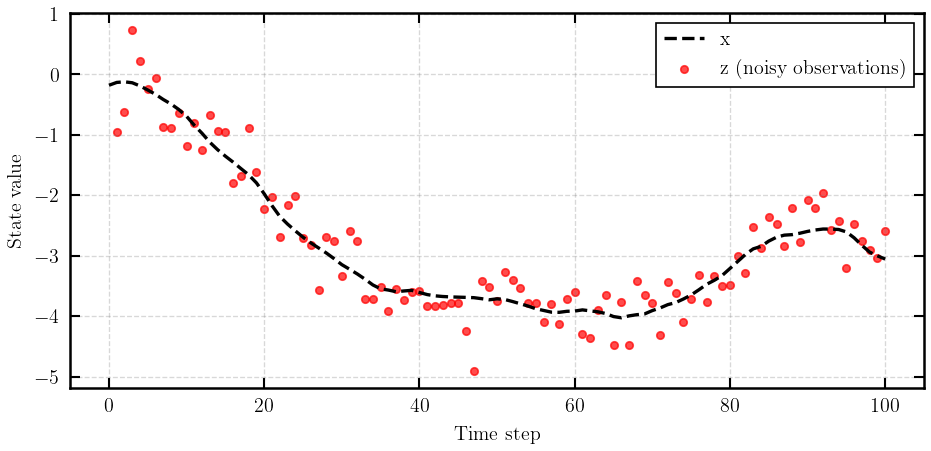

In [2]:
h = 0.1
sigma = 0.33
mu_0 = np.zeros(2)
Sigma_0 = np.eye(2)*0.33

A = np.array([[1, h], [0, 1]])
Q = np.array([[h**3/3, h**2/2], [h**2/2, h]])
H = np.array([[1, 0]])
R = np.array([[sigma]])

#Sample a true process
np.random.seed(6)
x_0 = np.random.multivariate_normal(mu_0, Sigma_0)
x_sequence = [x_0]
z_sequence = []
for i in range(100):
    x_sequence.append(np.random.multivariate_normal(A @ x_sequence[-1], Q))
    z_sequence.append(np.random.normal(H @ x_sequence[-1], R))
x_sequence = np.array(x_sequence)
z_sequence = np.array(z_sequence).reshape(-1,1)


plt.figure(figsize=(8, 4))
plt.plot(x_sequence[:, 0], label='x', color='black', linestyle='--')
#plt.plot(x_sequence[:, 1], label='x[1] (velocity)')
plt.scatter(range(1,len(z_sequence)+1), z_sequence, color='red', s=20, alpha=0.7, label='z (noisy observations)')
plt.xlabel('Time step')
plt.ylabel('State value')
plt.legend()
plt.grid(True)
plt.show()

In [3]:
ts = np.arange(101)

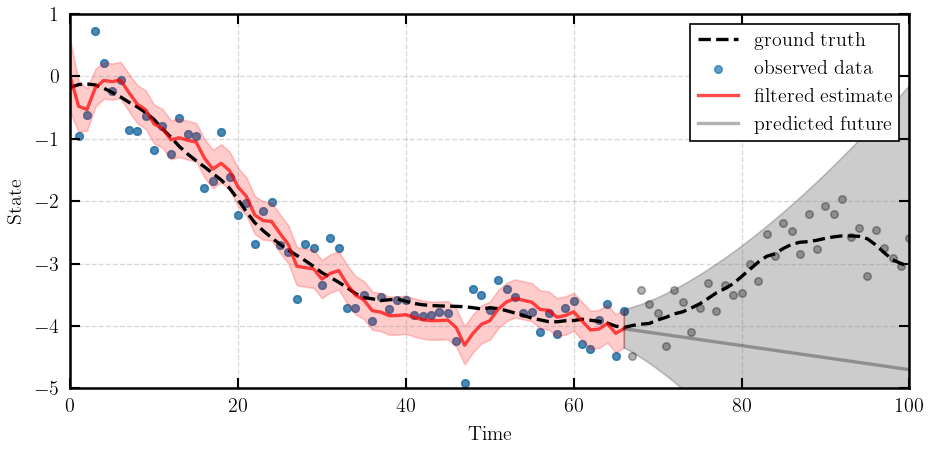

In [4]:
t=66
m_projected, P_projected, m_future_projected, P_future_projected = kalman_filter(t, 101, mu_0, Sigma_0, A, Q, H, R, z_sequence)
plot_kalman_filter(t, ts, m_projected, P_projected, m_future_projected, P_future_projected, x_sequence=x_sequence[:,0], z_sequence=z_sequence, x_lim=[0,100], y_lim=[-5,1])

In [5]:
for t in tqdm(range(101)):
    m_projected, P_projected, m_future_projected, P_future_projected = kalman_filter(t, 101, mu_0, Sigma_0, A, Q, H, R, z_sequence)
    plot_kalman_filter(t, ts, m_projected, P_projected, m_future_projected, P_future_projected, x_sequence[:,0], z_sequence, savefig=True)

100%|██████████| 101/101 [00:16<00:00,  6.22it/s]


### Smoothing Procedure

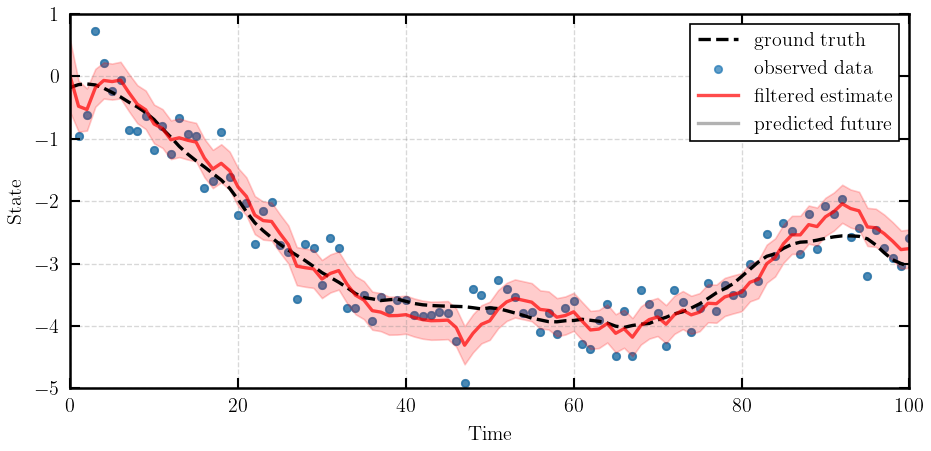

In [ ]:
t=100
m_projected, P_projected, m_future_projected, P_future_projected = kalman_filter(t, 101, mu_0, Sigma_0, A, Q, H, R, z_sequence)
plot_kalman_filter(t, ts, m_projected, P_projected, m_future_projected, P_future_projected, x_sequence=x_sequence[:,0], z_sequence=z_sequence, x_lim=[0,100], y_lim=[-5,1])

In [8]:
m_sequence = [mu_0]
P_sequence = [Sigma_0] 
m_sequence_predicted = [mu_0]
P_sequence_predicted = [Sigma_0]
for t in range(100):
    (m_prime, P_prime), (m_prime_predicted, P_prime_predicted) = filter(m_sequence[-1], P_sequence[-1], A, Q, H, R, z_sequence[t])
    m_sequence.append(m_prime)
    P_sequence.append(P_prime)
    m_sequence_predicted.append(m_prime_predicted)
    P_sequence_predicted.append(P_prime_predicted)

m_sequence = np.array(m_sequence)
P_sequence = np.array(P_sequence)
m_sequence_predicted = np.array(m_sequence_predicted)
P_sequence_predicted = np.array(P_sequence_predicted)

In [9]:
m_smoothed = [m_sequence[-1]]
P_smoothed = [P_sequence[-1]]
for t in tqdm(range(1,101)):
    m_smoothed_previous, P_smoothed_previous = smoother(m_sequence[100-t], P_sequence[100-t], A, m_sequence_predicted[101-t], P_sequence_predicted[101-t], m_smoothed[-1], P_smoothed[-1])
    m_smoothed.append(m_smoothed_previous)
    P_smoothed.append(P_smoothed_previous)

#flip the smoothed sequence
m_smoothed = m_smoothed[::-1]
P_smoothed = P_smoothed[::-1]

m_smoothed = np.array(m_smoothed)
P_smoothed = np.array(P_smoothed)

m_smoothed_projected = m_smoothed@H.T
P_smoothed_projected = np.array(P_smoothed)[:,0,0]
m_smoothed_projected = m_smoothed_projected.squeeze()
P_smoothed_projected = P_smoothed_projected.squeeze()

m_projected = m_sequence@H.T
P_projected = np.array(P_sequence)[:,0,0]
m_projected = m_projected.squeeze()
P_projected = P_projected.squeeze()


100%|██████████| 100/100 [00:00<00:00, 67847.04it/s]


In [10]:
def plot_smoothed_estimate(t):
    plt.figure(figsize=(8, 4))
    plt.plot(x_sequence[:, 0], label='ground truth', color='black', linestyle='--')
    plt.scatter(ts[1:], z_sequence, s=20, alpha=0.7, label='observed data')
    plt.plot(ts[:t+1], m_projected[:t+1], color='red', alpha=0.7, label='filtered estimate')
    plt.fill_between(ts[:t+1], m_projected[:t+1] - np.sqrt(P_projected[:t+1]), m_projected[:t+1] + np.sqrt  (P_projected[:t+1]), color='red', alpha=0.2)

    plt.plot(ts[t:], m_smoothed_projected[t:], color='blue', alpha=0.7, label='smoothed estimate')
    plt.fill_between(ts[t:], m_smoothed_projected[t:] - np.sqrt(P_smoothed_projected[t:]),  m_smoothed_projected[t:] + np.sqrt(P_smoothed_projected[t:]), color='blue', alpha=0.2)

    #plt.axvline(x=t, color='black', alpha=0.3, label='current time')
    #plt.yticks(np.arange(-8, 2, 1))
    plt.ylim(-5, 1)
    plt.xlim(0, 100)
    plt.xlabel('Time')
    plt.ylabel('State')
    plt.legend(loc='upper right')
    plt.grid(True)
    #plt.show()
    plt.savefig(f'smoother_imgs/kalman_filter_{t}.png')
    plt.close()

In [11]:
for t in range(101):
    plot_smoothed_estimate(t)

### EKF0

### EKF1


In [5]:
#define a nonlinear observation function
g = lambda x: x[0] + 0.3 * np.sin(5*x[0]) - 0.1  + 0.1*x[1]**3

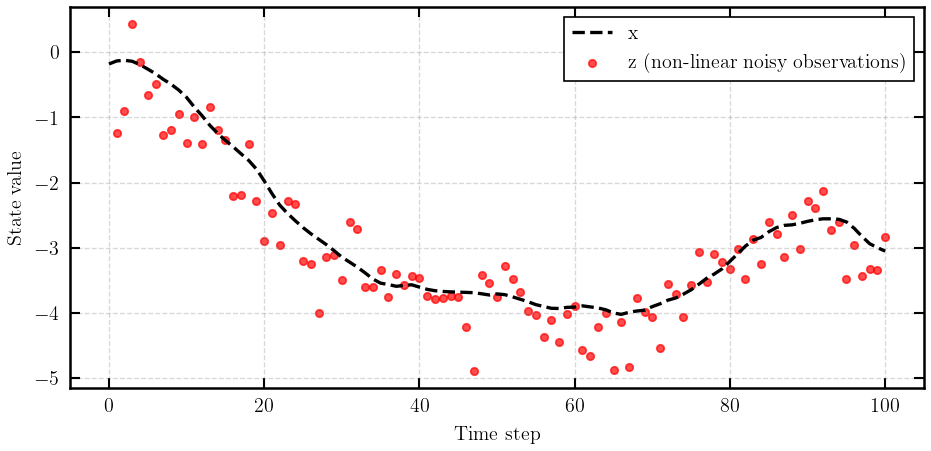

In [6]:
h = 0.1
sigma = 0.33
mu_0 = np.zeros(2)
Sigma_0 = np.eye(2)*0.33

A = np.array([[1, h], [0, 1]])
Q = np.array([[h**3/3, h**2/2], [h**2/2, h]])
H = np.array([[1, 0]])
R = np.array([[sigma]])

#Sample a true process
np.random.seed(6)
x_0 = np.random.multivariate_normal(mu_0, Sigma_0)
x_sequence = [x_0]
z_sequence = []
for i in range(100):
    x_sequence.append(np.random.multivariate_normal(A @ x_sequence[-1], Q))
    z_sequence.append(np.random.normal(g(x_sequence[-1]), R))
x_sequence = np.array(x_sequence)
z_sequence = np.array(z_sequence).reshape(-1,1)

# get the nonlinear observation


plt.figure(figsize=(8, 4))
plt.plot(x_sequence[:, 0], label='x', color='black', linestyle='--')
#plt.plot(x_sequence[:, 1], label='x[1] (velocity)')
plt.scatter(range(1,len(z_sequence)+1), z_sequence, color='red', s=20, alpha=0.7, label='z (non-linear noisy observations)')
plt.xlabel('Time step')
plt.ylabel('State value')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
#Autodiff jacobian 
jacobian_g = jacobian(g)
x0 = np.array(x_sequence[0])
J = jacobian_g(x0)
print(J)

[1.93765733 0.05261323]


In [8]:
z_sequence.shape

(100, 1)

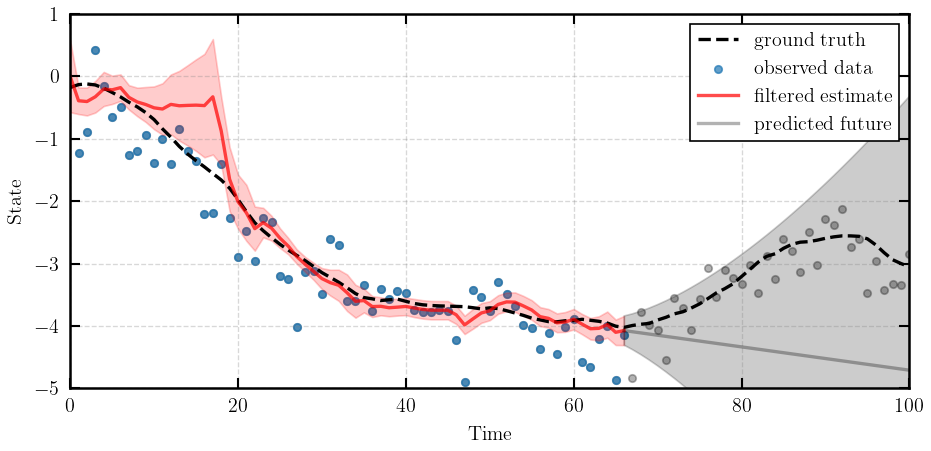

In [ ]:
t = 66
m_projected, P_projected, m_future_projected, P_future_projected = extended_kalman_filter(t, 101, mu_0, Sigma_0, A, Q, R, z_sequence, g, jacobian_g)
plot_kalman_filter(t, ts, m_projected, P_projected, m_future_projected, P_future_projected, x_sequence=x_sequence[:,0], z_sequence=z_sequence, x_lim=[0,100], y_lim=[-5,1])


In [12]:
for t in tqdm(range(101)):
    m_projected, P_projected, m_future_projected, P_future_projected = extended_kalman_filter(t, 101, mu_0, Sigma_0, A, Q, R, z_sequence, g, jacobian_g)
    plot_kalman_filter(t, ts, m_projected, P_projected, m_future_projected, P_future_projected, x_sequence[:,0], z_sequence, savefig=True)

100%|██████████| 101/101 [00:16<00:00,  6.07it/s]


#### Smoothing


In [39]:
m_sequence = [mu_0]
P_sequence = [Sigma_0] 
m_sequence_predicted = [mu_0]
P_sequence_predicted = [Sigma_0]
for t in range(100):
    linearization_point = m_sequence[-1]
    H = jacobian_g(linearization_point).reshape(1,-1)
    c = g(linearization_point) - H @ linearization_point
    (m_prime, P_prime), (m_prime_predicted, P_prime_predicted) = filter_affine(m_sequence[-1], P_sequence[-1], A, Q, H, c, R, z_sequence[t])
    m_sequence.append(m_prime)
    P_sequence.append(P_prime)
    m_sequence_predicted.append(m_prime_predicted)
    P_sequence_predicted.append(P_prime_predicted)

m_sequence = np.array(m_sequence)
P_sequence = np.array(P_sequence)
m_sequence_predicted = np.array(m_sequence_predicted)
P_sequence_predicted = np.array(P_sequence_predicted)

In [43]:
m_smoothed = [m_sequence[-1]]
P_smoothed = [P_sequence[-1]]
for t in tqdm(range(1,101)):
    m_smoothed_previous, P_smoothed_previous = smoother(m_sequence[100-t], P_sequence[100-t], A, m_sequence_predicted[101-t], P_sequence_predicted[101-t], m_smoothed[-1], P_smoothed[-1])
    m_smoothed.append(m_smoothed_previous)
    P_smoothed.append(P_smoothed_previous)

#flip the smoothed sequence
m_smoothed = m_smoothed[::-1]
P_smoothed = P_smoothed[::-1]

m_smoothed = np.array(m_smoothed)
P_smoothed = np.array(P_smoothed)

m_smoothed_projected = m_smoothed[:,0]
P_smoothed_projected = np.array(P_smoothed)[:,0,0]
m_smoothed_projected = m_smoothed_projected.squeeze()
P_smoothed_projected = P_smoothed_projected.squeeze()

m_projected = m_sequence[:,0]
P_projected = np.array(P_sequence)[:,0,0]
m_projected = m_projected.squeeze()
P_projected = P_projected.squeeze()


100%|██████████| 100/100 [00:00<00:00, 70080.27it/s]


In [45]:
for t in range(101):
    plot_smoothed_estimate(t)